In [37]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

In [2]:
data  = pd.read_csv('https://www.ee.iitb.ac.in/~asethi/Dump/MouseTrain.csv')

In [3]:
print(data.describe())

         DYRK1A_N     ITSN1_N      BDNF_N       NR1_N      NR2A_N      pAKT_N  \
count  762.000000  762.000000  762.000000  762.000000  762.000000  762.000000   
mean     0.437715    0.629456    0.319844    2.311905    3.882665    0.232722   
std      0.275175    0.274954    0.046536    0.342923    0.929202    0.039521   
min      0.170634    0.264085    0.194160    1.414914    1.794716    0.063236   
25%      0.294759    0.481011    0.290199    2.069609    3.186726    0.206446   
50%      0.371534    0.569058    0.317696    2.309711    3.800418    0.229032   
75%      0.486749    0.700621    0.346747    2.534053    4.471656    0.255064   
max      2.516367    2.602662    0.497160    3.757641    8.482553    0.434624   

          pBRAF_N   pCAMKII_N     pCREB_N      pELK_N  ...       SHH_N  \
count  762.000000  762.000000  762.000000  762.000000  ...  762.000000   
mean     0.182514    3.513055    0.212083    1.447201  ...    0.226365   
std      0.026548    1.268395    0.031066    0.5

In [4]:
x = data.iloc[:, :-2]
y1 = data.iloc[:,-2:-1]
y2 = data.iloc[:,-1]

In [5]:
le_1= LabelEncoder()
y1 = le_1.fit_transform(y1)
le_2 = LabelEncoder() #for multi-class
y22 = le_2.fit_transform(y2)

In [6]:
col_lst = []
for col in x.columns.values:
  col_lst.append(col)
  lst_vl = pd.unique(x[col])
  print(col + ' is of type ' + str(x[col].dtype) + ' has ' + str(len(lst_vl)) + ' unique values and ' + str(x[col].isnull().sum()) + ' null values' )

DYRK1A_N is of type float64 has 762 unique values and 0 null values
ITSN1_N is of type float64 has 761 unique values and 0 null values
BDNF_N is of type float64 has 762 unique values and 0 null values
NR1_N is of type float64 has 762 unique values and 0 null values
NR2A_N is of type float64 has 762 unique values and 0 null values
pAKT_N is of type float64 has 762 unique values and 0 null values
pBRAF_N is of type float64 has 760 unique values and 0 null values
pCAMKII_N is of type float64 has 762 unique values and 0 null values
pCREB_N is of type float64 has 762 unique values and 0 null values
pELK_N is of type float64 has 762 unique values and 0 null values
pERK_N is of type float64 has 762 unique values and 0 null values
pJNK_N is of type float64 has 761 unique values and 0 null values
PKCA_N is of type float64 has 762 unique values and 0 null values
pMEK_N is of type float64 has 762 unique values and 0 null values
pNR1_N is of type float64 has 762 unique values and 0 null values
pNR

In [7]:

imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(x)
x = imp.transform(x)

In [8]:

scaler = preprocessing.StandardScaler()
scaler.fit(x)
x = pd.DataFrame(scaler.transform(x),columns = col_lst)

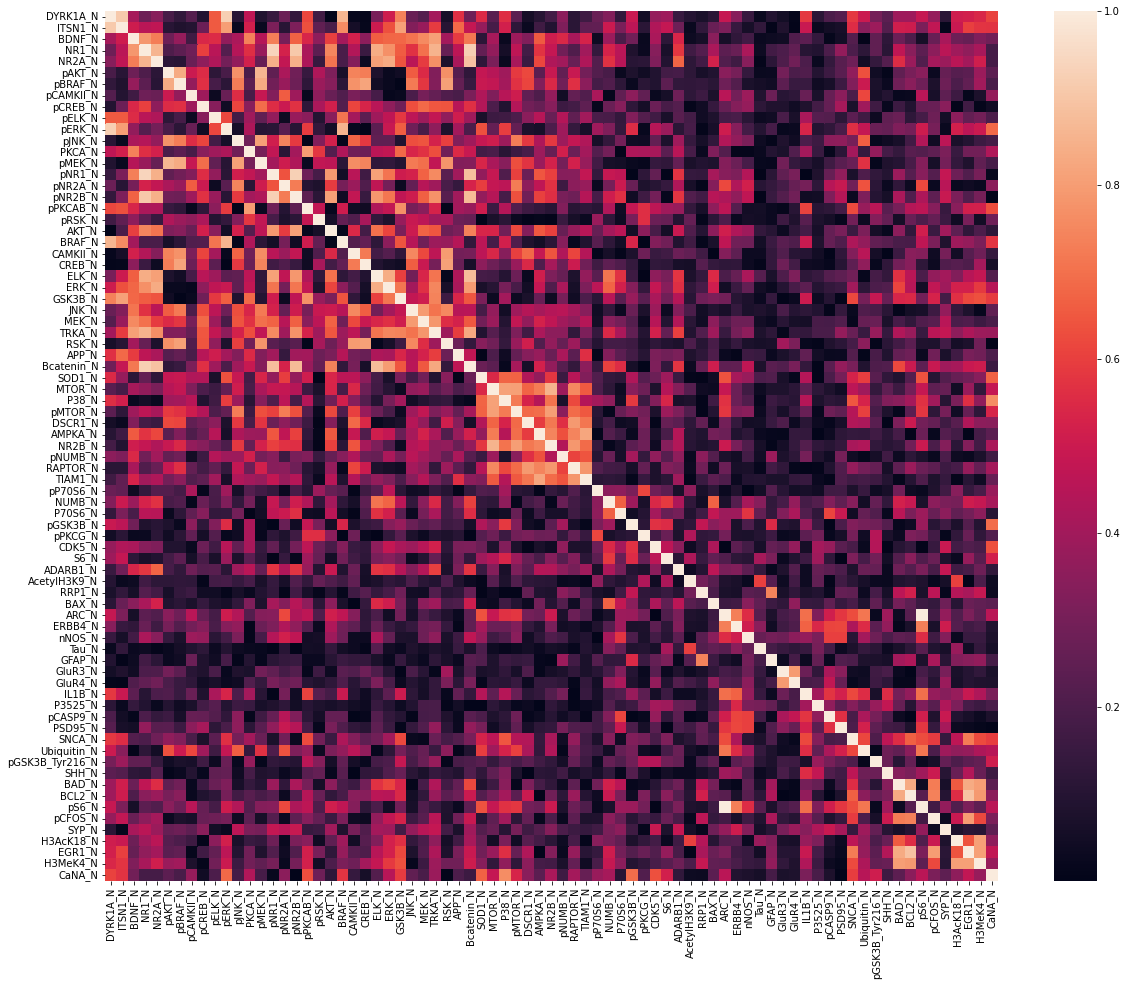

In [9]:
cor_matrix = x.corr(method = 'spearman').abs()
fig, ax  = plt.subplots(figsize = (20,16))
sns.heatmap(cor_matrix,annot = False)
plt.show()

In [10]:
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.90)]
    
print(to_drop)

['ITSN1_N', 'pERK_N', 'pNR1_N', 'pNR2B_N', 'Bcatenin_N', 'pS6_N']


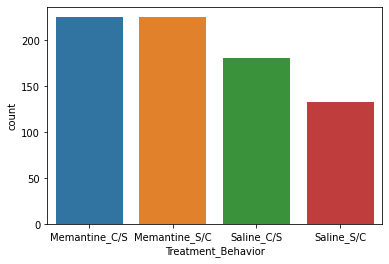

In [11]:
g = sns.countplot(data['Treatment_Behavior'])

g.set_xticklabels(['Memantine_C/S' ,'Memantine_S/C' ,'Saline_C/S' ,'Saline_S/C'])

plt.show()

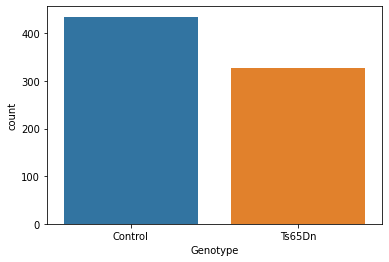

In [12]:
g = sns.countplot(data['Genotype'])

g.set_xticklabels(['Control','Ts65Dn'])

plt.show()

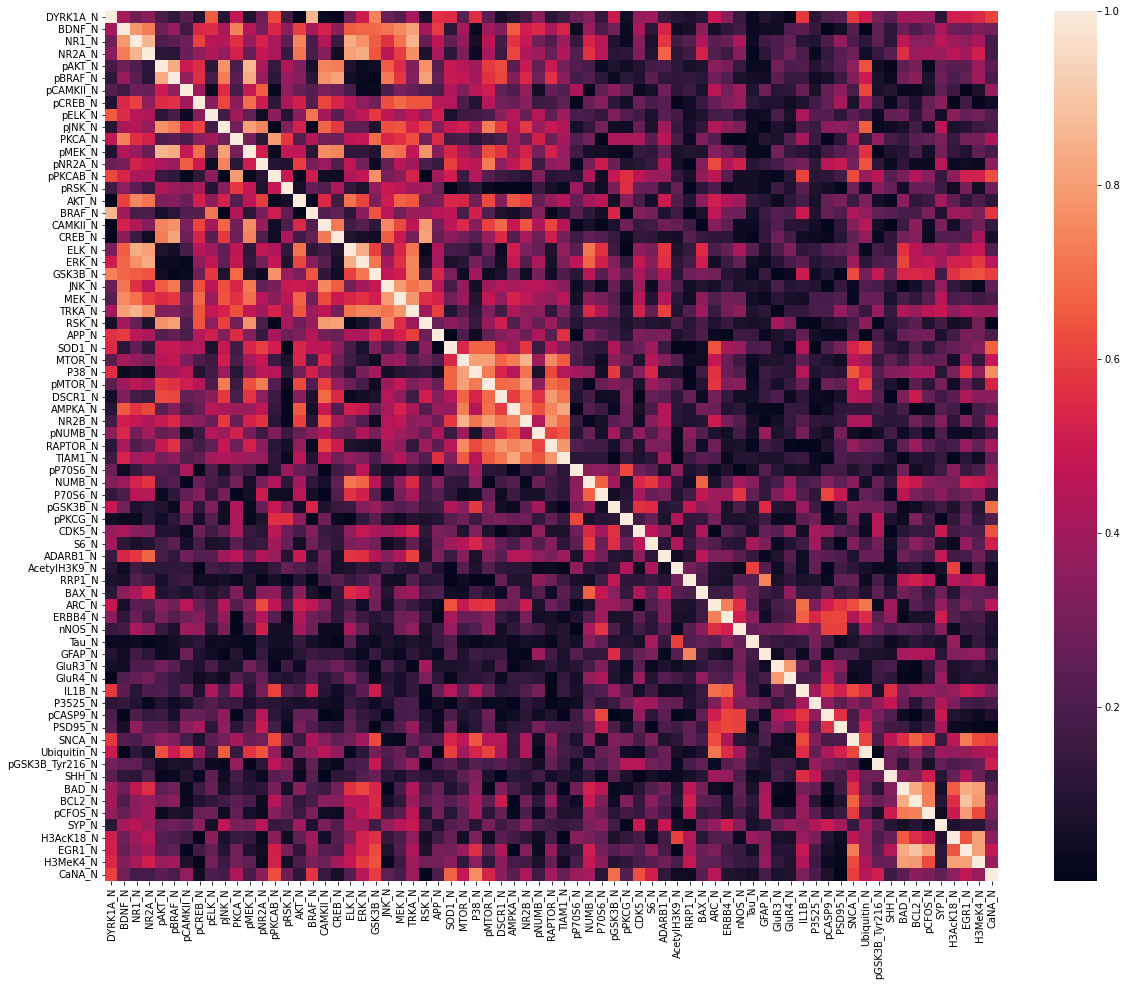

In [13]:
xd = x.drop(to_drop,axis = 1)
corrmat = xd.corr(method = 'spearman')
fig, ax  = plt.subplots(figsize = (20,16))
sns.heatmap(abs(corrmat),annot = False)
plt.show()

In [14]:
# Resonable hyper-parameters for binary classification using Neural network with single ReLU hidden layer and Softmax output (number of neurons, weight decay)
from sklearn.neural_network import MLPClassifier
mod = MLPClassifier(activation='relu') #‘relu’, the rectified linear unit function, returns f(x) = max(0, x)
param = {'alpha':[0.001, 0.01, 0.1,1,10],'hidden_layer_sizes':[(10,),(15,),(20,),(30,),(50,)]} #In hidden layer sizes the ith element represents the number of neurons in ith hidden layer
scoring = ['balanced_accuracy','f1','roc_auc']
for i in scoring:
  clf = GridSearchCV(estimator = mod,param_grid=param,scoring = i)
  clf.fit(np.array(xd),np.squeeze(y1))
  print('Best param')
  print(clf.best_params_)
  print('best ' + i+ ':' + str(clf.best_score_))

Best param
{'alpha': 1, 'hidden_layer_sizes': (30,)}
best balanced_accuracy:0.748689012137288
Best param
{'alpha': 1, 'hidden_layer_sizes': (50,)}
best f1:0.7178208613320741
Best param
{'alpha': 1, 'hidden_layer_sizes': (50,)}
best roc_auc:0.7969771990461646


In [15]:
# Resonable hyper-parameters for multi-class classification using Neural network with single ReLU hidden layer and Softmax output (number of neurons, weight decay)
scoring = ['f1_macro','roc_auc_ovr']
for i in scoring:
  clf = GridSearchCV(estimator = mod,param_grid=param,scoring = i)
  clf.fit(np.array(xd),np.squeeze(y22))
  print('Best param')
  print(clf.best_params_)
  print('best ' + i+ ':' + str(clf.best_score_))

Best param
{'alpha': 0.001, 'hidden_layer_sizes': (50,)}
best f1_macro:0.7368741550429474
Best param
{'alpha': 0.1, 'hidden_layer_sizes': (10,)}
best roc_auc_ovr:0.9119468600666231


In [16]:
#Resonable hyper-parameters for binary classification using SVM
hyper = {'kernel':('rbf','linear','poly'),'C':[.001,.01,1,10],'degree':[2,3,5,8]}
svc = svm.SVC(probability=True)
scoring = ['balanced_accuracy','f1','roc_auc']
for i in scoring:
  clf = GridSearchCV(estimator = svc,param_grid=hyper,scoring = i)
  clf.fit(np.array(xd),np.squeeze(y1))
  print('Best param')
  print(clf.best_params_)
  print('best ' + i+ ':' + str(clf.best_score_))

Best param
{'C': 0.01, 'degree': 2, 'kernel': 'linear'}
best balanced_accuracy:0.7943533478016236
Best param
{'C': 0.01, 'degree': 2, 'kernel': 'linear'}
best f1:0.7627587395089508
Best param
{'C': 0.01, 'degree': 2, 'kernel': 'linear'}
best roc_auc:0.8491230608471987


In [17]:
#Resonable hyper-parameters for Multi-class classification using SVM
scoring = ['f1_macro','roc_auc_ovr']
for i in scoring:
  clf = GridSearchCV(estimator = svc,param_grid=hyper,scoring = i)
  clf.fit(np.array(xd),y22)
  print('Best param')
  print(clf.best_params_)
  print('best ' + i+ ':' + str(clf.best_score_))

Best param
{'C': 1, 'degree': 2, 'kernel': 'linear'}
best f1_macro:0.7386774372767196
Best param
{'C': 10, 'degree': 3, 'kernel': 'rbf'}
best roc_auc_ovr:0.9100558336331513


In [18]:
#Here we are using SVM estimator with linear kernel for binary classification
svc = svm.SVC(kernel = 'linear')
svc.fit(xd,y1)
selector = RFECV(estimator = svc, step=1, cv=2)
selector = selector.fit(xd, y1)
z = selector.ranking_ #here we can see the ranking of features that are helpful in predicting the target
print("Ranking of features\n",z)

Ranking of features
 [ 6 46  3 27 23 50 17 31 58 25 33 66 24 65 35 29  7 32 16 28  1 48 51 42
  2 22  1 49  5 39 37 10  1 62  4 20  1 21  1 26 60 14 44 45 30 55 64 52
 59  8 53 56 61  1 43 40 41 11 47 15 19 13 57 63 38 18  9 54 36 34 12]


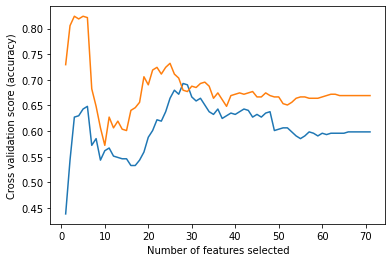

In [19]:
#Checking how many features will contribute to the target variable by plotting
min_features_to_select = 1
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(min_features_to_select, len(selector.grid_scores_) + min_features_to_select),
    selector.grid_scores_,
)
plt.show()

In [20]:
q = selector.feature_names_in_
res = dict(zip(q,z)) #Here we are mmaking dictionary with key as features and their values as their corresponding ranking
col_1 = []

for i,j in res.items():
  if j<=8:
    col_1.append(i)
col_1                #Here column 1 is the list of all the selected features with ranking <=8

['DYRK1A_N',
 'NR1_N',
 'BRAF_N',
 'ERK_N',
 'TRKA_N',
 'APP_N',
 'MTOR_N',
 'AMPKA_N',
 'pNUMB_N',
 'TIAM1_N',
 'NUMB_N',
 'ERBB4_N',
 'GluR3_N']

In [21]:
x1 = pd.DataFrame(xd,columns=col_1 )

In [22]:
from sklearn.feature_selection import RFECV #Here we are using SVM estimator with linear kernel for multi-class classification
svc = svm.SVC(kernel = 'linear')
svc.fit(xd,y22)
selector = RFECV(estimator = svc, step=1, cv=10)
selector = selector.fit(xd, y22)
z = selector.ranking_
z

array([ 6,  5,  1,  1, 26,  2,  1,  1, 30,  1, 18, 33,  1,  1, 39,  1,  1,
        1, 25, 16,  1,  1, 29, 10,  1, 23,  1,  1,  8,  1, 14,  1, 31, 38,
        1, 19, 12, 27, 21,  9, 34,  3,  1,  1, 15, 11, 17,  7, 20, 28,  1,
        1,  1,  1, 24,  1,  1,  1, 35, 13,  1,  1,  4, 41, 22, 36, 40, 37,
       42, 32,  1])

In [23]:
res = dict(zip(q,z)) 
col_2 = []

for i,j in res.items():
  if j<=8:
    col_2.append(i)
col_2   

['DYRK1A_N',
 'BDNF_N',
 'NR1_N',
 'NR2A_N',
 'pBRAF_N',
 'pCAMKII_N',
 'pCREB_N',
 'pJNK_N',
 'pNR2A_N',
 'pPKCAB_N',
 'AKT_N',
 'BRAF_N',
 'CAMKII_N',
 'ERK_N',
 'GSK3B_N',
 'TRKA_N',
 'APP_N',
 'SOD1_N',
 'MTOR_N',
 'P38_N',
 'DSCR1_N',
 'pNUMB_N',
 'pPKCG_N',
 'CDK5_N',
 'S6_N',
 'BAX_N',
 'nNOS_N',
 'Tau_N',
 'GFAP_N',
 'GluR3_N',
 'IL1B_N',
 'P3525_N',
 'pCASP9_N',
 'Ubiquitin_N',
 'pGSK3B_Tyr216_N',
 'SHH_N',
 'CaNA_N']

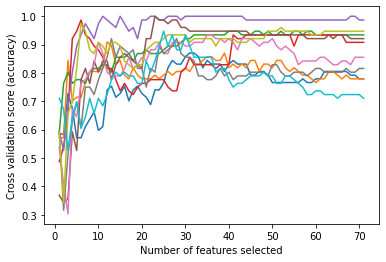

In [24]:
x2 = pd.DataFrame(xd,columns=col_2)
min_features_to_select = 1
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(min_features_to_select, len(selector.grid_scores_) + min_features_to_select),
    selector.grid_scores_,
)
plt.show()

In [25]:
hyper = {'kernel':('rbf','linear','poly'),'C':[.001,.01,1,10],'degree':[2,3,5,8]} #using SVM for binary
svc = svm.SVC(probability=True)
scoring = ['balanced_accuracy','f1','roc_auc']

#x = x['ELK_N','ERK_N']
for i in scoring:
  clf = GridSearchCV(estimator = svc,param_grid=hyper,scoring = i)
  clf.fit(np.array(x1),np.squeeze(y1))
  print('Best param')
  print(clf.best_params_)
  print('best ' + i+ ':' + str(clf.best_score_))

Best param
{'C': 1, 'degree': 2, 'kernel': 'linear'}
best balanced_accuracy:0.8790515231894542
Best param
{'C': 1, 'degree': 2, 'kernel': 'linear'}
best f1:0.8619461015052112
Best param
{'C': 1, 'degree': 2, 'kernel': 'linear'}
best roc_auc:0.9550625619591135


In [26]:
scoring = ['f1_macro','roc_auc_ovr']  #using SVM for multi-class
for i in scoring:
  clf = GridSearchCV(estimator = svc,param_grid=hyper,scoring = i)
  clf.fit(np.array(x2),y22)
  print('Best param')
  print(clf.best_params_)
  print('best ' + i+ ':' + str(clf.best_score_))

Best param
{'C': 10, 'degree': 2, 'kernel': 'linear'}
best f1_macro:0.8428961809802145
Best param
{'C': 10, 'degree': 3, 'kernel': 'linear'}
best roc_auc_ovr:0.9551023111810387


In [27]:
from sklearn.neural_network import MLPClassifier  #using neural network for binary
mod = MLPClassifier()
param = {'alpha':[0.001, 0.01, 0.1,1,10],'hidden_layer_sizes':[(10,),(15,),(20,),(30,),(50,)]}
scoring = ['balanced_accuracy','f1','roc_auc']
for i in scoring:
  clf = GridSearchCV(estimator = mod,param_grid=param,scoring = i)
  clf.fit(np.array(x1),np.squeeze(y1))
  print('Best param')
  print(clf.best_params_)
  print('best ' + i+ ':' + str(clf.best_score_))

Best param
{'alpha': 1, 'hidden_layer_sizes': (20,)}
best balanced_accuracy:0.9038807169841652
Best param
{'alpha': 0.1, 'hidden_layer_sizes': (30,)}
best f1:0.8972907412659883
Best param
{'alpha': 0.1, 'hidden_layer_sizes': (20,)}
best roc_auc:0.9666446962998686


In [28]:
scoring = ['f1_macro','roc_auc_ovr']  #using neural network for multi-class
for i in scoring:
  clf = GridSearchCV(estimator = mod,param_grid=param,scoring = i)
  clf.fit(np.array(x2),np.squeeze(y22))
  print('Best param')
  print(clf.best_params_)
  print('best ' + i+ ':' + str(clf.best_score_))

Best param
{'alpha': 0.01, 'hidden_layer_sizes': (50,)}
best f1_macro:0.7643134796219522
Best param
{'alpha': 0.01, 'hidden_layer_sizes': (30,)}
best roc_auc_ovr:0.9300388322539377


In [29]:
test = pd.read_csv('https://www.ee.iitb.ac.in/~asethi/Dump/MouseTest.csv') #reading test data
test_x = test.iloc[:, :-2]
test_y = test.iloc[:,-2:].values

ty1 = test_y[:,:-1] #for binary
ty2 = test_y[:,-1]  #for multi-class

In [30]:
le = LabelEncoder()
ty1 = le.fit_transform(ty1)

le = LabelEncoder()
ty2 = le.fit_transform(ty2)

In [31]:
test_x = imp.transform(test_x)  #computing NAN values by using the same iterative computing that was used in training data
test_x = pd.DataFrame(scaler.transform(test_x),columns = col_lst)   #scaling the test variable by using same scaling factor used in training data
test_x1 = pd.DataFrame(test_x,columns=col_1 ) #features desirable for binary targets
test_x2 = pd.DataFrame(test_x,columns=col_2 ) #features desirable for multi-class targets

In [32]:
#fitting SVM model on binary class (due to high accuracy)
from sklearn import svm
svc1 = svm.SVC(kernel = 'linear',C = .02,degree =3)

svc1.fit(np.array(x1),np.squeeze(y1))
y_p1 = svc1.predict(test_x1) #predicted target variables for binary class

In [38]:
#checking accuracy of model on test data
from sklearn.metrics import f1_score
f1 = f1_score(y_p1, ty1)
print('f1: %.2f' % (f1*100))
roc = roc_auc_score(y_p1, ty1)
print('roc: %.2f' % (roc*100)) 

f1: 82.95
roc: 86.33


In [35]:
#fitting SVM model on multi-class (due to high accuracy)
svc = svm.SVC(kernel = 'linear',C = 10,degree = 2,probability=True)
svc.fit(np.array(x2),np.squeeze(y22))
y_p2 = svc.predict(test_x2) #predicted target variables for multi-class
y_pred_2 = svc.predict_proba(test_x2) # predicting probability of multiclass-data for roc_auc score

In [39]:
#checking accuracy of model on test data
from sklearn.metrics import f1_score
accuracy = f1_score(y_p2, ty2,average='macro')
print('f1_macro: %.2f' % (accuracy*100))
roc = roc_auc_score((ty2), y_pred_2, average='macro', multi_class='ovr') # Calculating accuracy
print('\n roc: ', roc*100)

f1_macro: 94.31

 roc:  98.90179573512906


In [40]:
#fitting neural network model on binary class
mod1 = MLPClassifier(alpha = .001,hidden_layer_sizes=(15,))
mod1.fit(np.array(x1),np.squeeze(y1))
y_p11 = mod1.predict(test_x1) #predicted target variables for binary class

In [41]:
f1 = f1_score(y_p11, ty1)
print('f1: %.2f' % (f1*100))
roc = roc_auc_score(y_p11, ty1)
print('roc: %.2f' % (roc*100)) 

f1: 82.22
roc: 85.19


In [42]:
#fitting neural network model on multi-class
mod2 = MLPClassifier(alpha = 1,hidden_layer_sizes=(20,))
mod1.fit(np.array(x2),np.squeeze(y22))
y_p22 = mod1.predict(test_x2) #predicted target variables for multiclass
y_pred22= mod1.predict_proba(test_x2) #predicting probability

In [43]:
#checking accuracy of model on test data
from sklearn.metrics import f1_score
accuracy = f1_score(y_p22, ty2,average='macro')
print('f1_macro: %.2f' % (accuracy*100))

roc = roc_auc_score((ty2), y_pred22, average='macro', multi_class='ovr') # Calculating accuracy
print('\n roc: ', roc*100)

f1_macro: 82.28

 roc:  97.3395061728395
